In [51]:
#%%[markdown]
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

from multiprocessing.pool import ThreadPool, Pool
import threading
from tqdm import tqdm
import csv

from os.path import exists

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

In [52]:
response = requests.get(
    "https://sea.wildstats.gg/en/leaderboard")
soup = BeautifulSoup(response.text, "html.parser")
elements = soup.findAll('a', attrs = {'class' : 'text-truncate'})
leaderboard = [
    (
        'https://sea.wildstats.gg'+element.attrs["href"], 
        element.findChildren("span")[0].text
    ) for element in elements
]

print(len(leaderboard))
print(leaderboard[:5])

200
[('https://sea.wildstats.gg/en/profile/D1pWIYi6Y5O5wfvRYG7T', 'Yasuo LoVe'), ('https://sea.wildstats.gg/en/profile/S4oFFBRE88hAEhs41Ike', 'RRQ Chazz'), ('https://sea.wildstats.gg/en/profile/6LYjywZ3n8oYUe1wPwto', 'NGX ChammY'), ('https://sea.wildstats.gg/en/profile/EROGPRmlwyIuf24AnFNY', 'RRQ Tatsurii'), ('https://sea.wildstats.gg/en/profile/YwMfAm4canvu06JXp7WW', 'xori eto lang aq')]


In [53]:
file_name = 'challengers.csv'

if not exists(file_name):
    threadLocal = threading.local()

    def get_driver():
        driver = getattr(threadLocal, 'driver', None)
        if driver is None:
            chrome_options = Options()
            chrome_options.add_argument("--headless")
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), 
                                        options=chrome_options)

            setattr(threadLocal, 'driver', driver)
        return driver

    def scrap(data):
        url, id = data

        driver = get_driver()

        driver.get(url)
        html = driver.page_source
        soup = BeautifulSoup(html, features="html.parser")
        row_datas = soup.findAll('h1', attrs={'class': 'text-center m-0'})

        row_datas_text = [data.text for data in row_datas]
        marks = soup.find('span', attrs={'class':'badge badge-overlay text-white'}).findAll('div')[1].text.strip()
        return (marks, *row_datas_text, url)

    with ThreadPool(5) as p:
        challenger_datas = list(tqdm(p.imap(scrap, leaderboard), total=len(leaderboard)))
    driver = get_driver()
    driver.quit()

    df = pd.DataFrame(challenger_datas, columns=['Marks', 'WinRate', 'MVP', 'Played', 'URL'])

    df.to_csv(file_name, index=False)
else:
    df = pd.read_csv(file_name)

In [54]:
print(df.head())

   Marks WinRate  MVP Played  \
0    244  58.53%  341  1,102   
1    234  62.05%  330    751   
2    221  64.34%  265    603   
3    214  61.81%  234    741   
4    200  59.08%  307    782   

                                                 URL  
0  https://sea.wildstats.gg/en/profile/D1pWIYi6Y5...  
1  https://sea.wildstats.gg/en/profile/S4oFFBRE88...  
2  https://sea.wildstats.gg/en/profile/6LYjywZ3n8...  
3  https://sea.wildstats.gg/en/profile/EROGPRmlwy...  
4  https://sea.wildstats.gg/en/profile/YwMfAm4can...  


In [55]:
df['Marks'] = df['Marks'].astype('int')
df['WinRate'] = df['WinRate'].str.rstrip('%').astype('float')
df['MVP'] = df['MVP'].astype('int') 
df['Played'] = df['Played'].astype('str').str.replace(',', '').astype('int')

In [56]:
# df['Marks']
# df['WinRate']
# df['MVP'] / df['Played']


0.2894330893889886


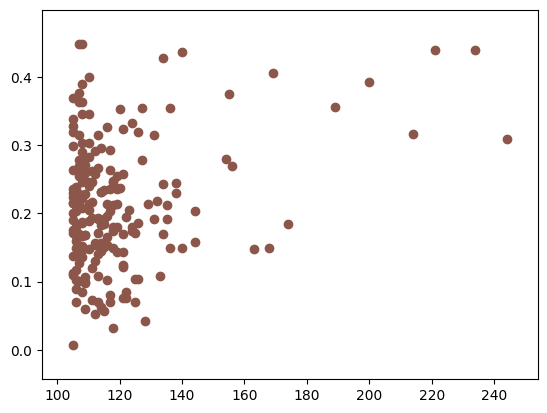

In [62]:
x = df['Marks']
y = df['MVP'] / df['Played']

print(np.corrcoef(x, y)[0, 1])

fig, ax = plt.subplots()

ax.set_xlim((x.min()-10, x.max()+10))
ax.set_ylim((y.min()-0.05, y.max()+0.05))

ax.plot(x, y, 'o', color='tab:brown')

plt.show()

0.27482239790956564


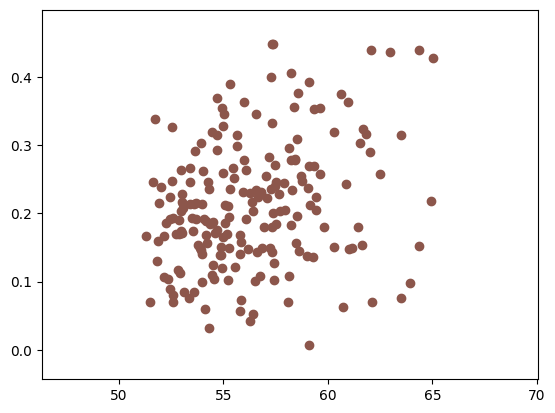

In [64]:
x = df['WinRate']
y = df['MVP'] / df['Played']

print(np.corrcoef(x, y)[0, 1])

fig, ax = plt.subplots()

ax.set_xlim((x.min()-5, x.max()+5))
ax.set_ylim((y.min()-0.05, y.max()+0.05))

ax.plot(x, y, 'o', color='tab:brown')

plt.show()